## <center>Detecting a marketing promotion</center>

### Description
Based on the example data, deduce which day a marketing promotion was launched.

Example data includes traffic and order activity over a period of several months. During this period a promotion offering free shipping was launched on the website. All visitors were exposed to the promotion and once started it remained active for all of the remaining days.

In [1]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import pymc3 as pm

%matplotlib inline

### Data investigation

In [2]:
df = pd.read_csv('data/marketing_promo.csv')
print(df.shape)
df.head(3)

(122, 3)


,Day,visits,orders
0,1,3316,17
1,2,3654,23
2,3,3437,14


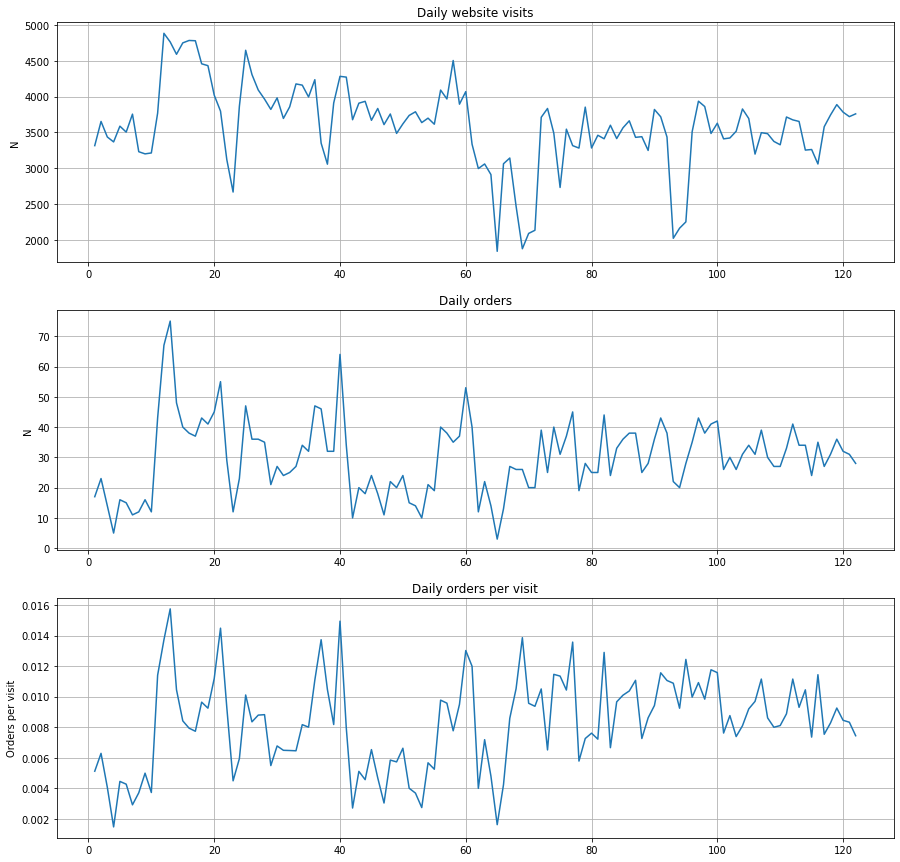

In [3]:
figsize(15, 15)

f = plt.figure()

ax = f.add_subplot(311)
plt.plot(df.Day, df.visits)
plt.title('Daily website visits')
plt.ylabel('N')
plt.grid()

ax1 = f.add_subplot(312, sharex=ax)
plt.plot(df.Day, df.orders)
plt.title('Daily orders')
plt.ylabel('N')
plt.grid()

ax2 = f.add_subplot(313)
plt.plot(df.Day, df.orders / df.visits)
plt.title('Daily orders per visit')
plt.ylabel('Orders per visit')
plt.grid()

### Modelling

In [4]:
# use orders per visit to predict a launch of a marketing campaign

data = df.orders / df.visits
N = len(data)

In [5]:
# Create a pyMC3 model.
# I'm going to use a Normal distribution to describe observed values of orders per visit.
# Assume that start of the campaign should result in observed step-like changes of the parameters of Normal distribution

with pm.Model() as model:
    # mu parameters before and after a promotion
    mu_1 = pm.Uniform('mu_1', lower=0, upper=data.max())
    mu_2 = pm.Uniform('mu_2', lower=0, upper=data.max())
    
    # sigma parameters before and after a promotion
    sigma_1 = pm.Uniform('sigma_1', lower=1e-3, upper=data.max()/2)
    sigma_2 = pm.Uniform('sigma_2', lower=1e-3, upper=data.max()/2)
    
    # Promo day
    tau = pm.DiscreteUniform("tau", lower=0, upper=N-1)

    #index
    idx = np.arange(N)
    
    # conditional mu and sigma used in the model
    mu = pm.math.switch(tau > idx, mu_1, mu_2)
    sigma = pm.math.switch(tau > idx, sigma_1, sigma_2)

    observation = pm.Normal("obs", mu=mu, sigma=sigma, observed=data)

In [6]:
# Run the model

with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [sigma_2]
>Metropolis: [sigma_1]
>Metropolis: [mu_2]
>Metropolis: [mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4073.51draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [7]:
# Extract distributions

mu_1_samples = trace['mu_1']
mu_2_samples = trace['mu_2']
sigma_1_samples = trace['sigma_1']
sigma_2_samples = trace['sigma_2']
tau_samples = trace['tau']

### Visualizations

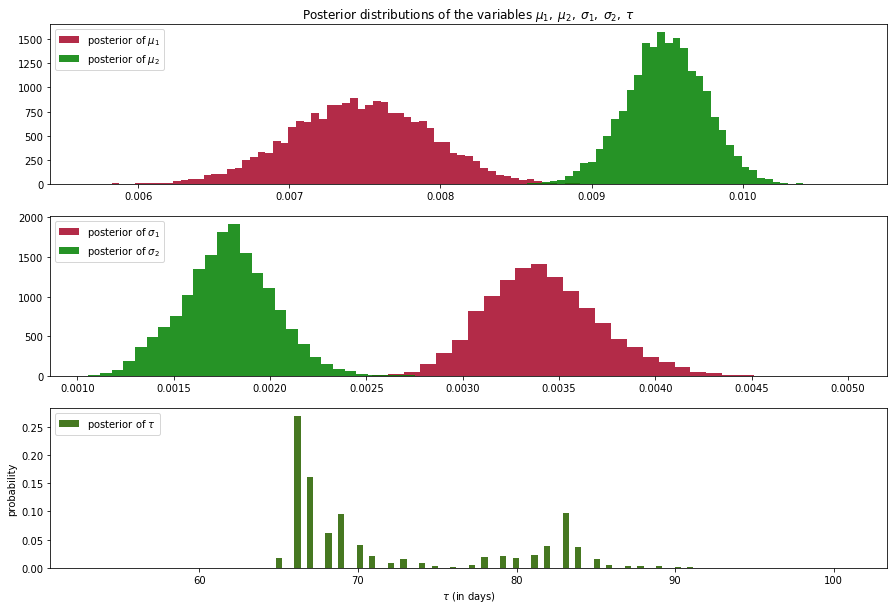

In [9]:
figsize(15, 10)

# mu_1 and mu_2
ax = plt.subplot(311)
bins = np.linspace(min(mu_1_samples.min(), mu_2_samples.min()),
                   max(mu_1_samples.max(), mu_2_samples.max()),
                   100)
plt.hist(mu_1_samples,
         histtype='stepfilled', bins=bins, alpha=0.85, density=True,
         label="posterior of $\mu_1$", color="#A60628")
plt.hist(mu_2_samples,
         histtype='stepfilled', bins=bins, alpha=0.85, density=True,
         label="posterior of $\mu_2$", color="green")
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables $\mu_1,\;\mu_2,\;\sigma_1,\;\sigma_2,\;\tau$""")

# sigma_1 and sigma_2
ax = plt.subplot(312)
bins = np.linspace(min(sigma_1_samples.min(), sigma_2_samples.min()),
                   max(sigma_1_samples.max(), sigma_2_samples.max()),
                   100)
plt.hist(sigma_1_samples,
         histtype='stepfilled', bins=30, alpha=0.85, density=True,
         label="posterior of $\sigma_1$", color="#A60628")
plt.hist(sigma_2_samples,
         histtype='stepfilled', bins=30, alpha=0.85, density=True,
         label="posterior of $\sigma_2$", color="green")
plt.legend(loc="upper left")

# tau
plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples,
         bins=N, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.legend(loc="upper left")
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

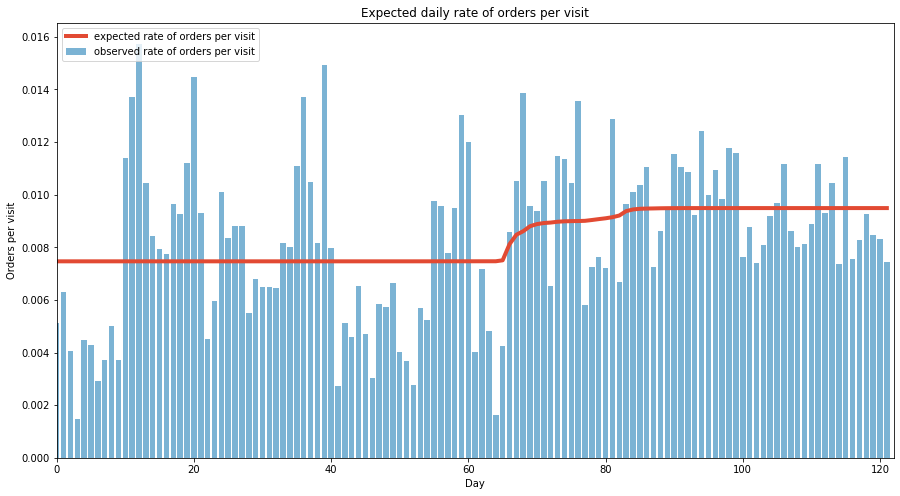

In [13]:
# Plot expected vs observed orders per visit

figsize(15, 8)

expected_orders_per_visit = np.zeros(N)
for day in range(N):
    ix = day < tau_samples  # bool index 
    expected_orders_per_visit[day] = (mu_1_samples[ix].sum() + mu_2_samples[~ix].sum()) / tau_samples.shape[0]


plt.bar(np.arange(N), data,
        color="#348ABD", alpha=0.65, label="observed rate of orders per visit")

plt.plot(range(N), expected_orders_per_visit,
         lw=4, color="#E24A33", label="expected rate of orders per visit")

plt.legend(loc="upper left")
plt.xlim(0, N)
plt.xlabel("Day")
plt.ylabel("Orders per visit")
_ = plt.title("Expected daily rate of orders per visit")